In [5]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn import metrics
from sklearn import linear_model
from sklearn import datasets
from sklearn import preprocessing, utils
from sklearn.metrics import  make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [7]:
df_bankrupt = pd.read_csv("bankrupt.csv")
df_bankrupt.shape

(10000, 65)

In [8]:
df_bankrupt.rename(columns={ df_bankrupt.columns[-1]: "y" }, inplace = True)
df_bankrupt.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,y
0,-0.031545,-0.091313,-0.040269,-0.013529,0.007406,-0.016047,-0.000264,0.641242,-0.748385,0.126789,...,0.014367,0.005457,-0.014143,-0.020924,0.068399,-0.214478,-0.013915,-0.173939,-0.046788,0
1,-0.231729,-0.049448,0.304381,-0.080975,0.007515,-0.016047,-0.034963,0.074710,0.469815,0.073759,...,0.008492,-0.008385,-0.008666,-0.023095,-0.033498,-0.205796,-0.015174,-0.073056,-0.027236,0
2,-0.058602,0.065060,-0.488404,-0.189489,0.006572,-0.016047,-0.004954,-0.456287,0.270351,-0.071287,...,0.010819,0.006779,-0.009437,-0.007919,-0.043455,0.019740,-0.011736,-0.291624,-0.033580,0
3,-0.069376,0.044641,-0.181684,-0.140032,0.007477,-0.010915,-0.005599,-0.462971,-0.286746,-0.085266,...,0.010683,0.005384,-0.010840,0.001381,-0.042828,-0.350519,0.002969,-0.554685,-0.046823,0
4,0.236424,-0.051912,0.678337,-0.014680,0.007879,-0.016047,0.057418,0.097183,0.423405,0.076880,...,0.010970,0.025295,-0.011056,-0.022535,-0.035892,-0.181557,-0.015623,-0.027841,-0.023694,0


In [11]:
x = df_bankrupt.to_numpy()[:,:-1]
y = df_bankrupt.to_numpy()[:,-1]
np.unique(y)

0.0203

In [4]:
df_bankrupt.dtypes

Attr1     float64
Attr2     float64
Attr3     float64
Attr4     float64
Attr5     float64
           ...   
Attr61    float64
Attr62    float64
Attr63    float64
Attr64    float64
y           int64
Length: 65, dtype: object

In [5]:
#divide data into x and y
x = df_bankrupt.iloc[:,:-1]
y = df_bankrupt.y

#seeing %pos in the data
pos = y.sum()
neg = len(y) - pos

percent_pos = round(pos/len(y)*100, 2)
percent_neg = round(neg/len(y)*100, 2)

percent_pos

2.03

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

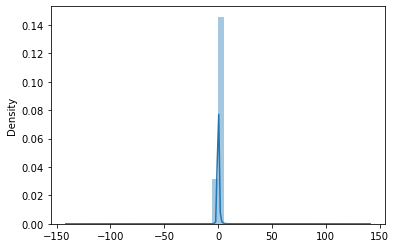

In [6]:
#checking the shape of the datasets
sns.distplot(df_bankrupt, kde=True)

In [12]:
#since it is approximately normal, we will standardize using z dist
x_std = preprocessing.scale(x).astype(np.float32)
y_std = y
print(np.sum(y_std==0),np.sum(y_std==1))

9797 203


In [12]:
x_std.shape

(10000, 64)

In [27]:
result_lr = []
for trial in range(2):
    #splitting into training and testing
    x_train, x_test, y_train, y_test = train_test_split(x_std, y_std, train_size = 5000, random_state=trial,
                                                    stratify = y_std, shuffle=True)

    #encode training and testing data != continuous
    encode_ytr = preprocessing.LabelEncoder()
    ytr_encoded = encode_ytr.fit_transform(y_train)
    print(np.sum(ytr_encoded==1))
    
    encode_yt = preprocessing.LabelEncoder()
    yt_encoded = encode_yt.fit_transform(y_test)
    print(np.sum(yt_encoded==1))
    
    C_list = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, np.Inf]
    alg = LogisticRegression(max_iter=50, solver='saga')
    param_grid =  {'penalty' : ['l1', 'l2'], 'C': C_list}
    scoring_list = ['accuracy', 'precision', 'f1', 'roc_auc', 'recall']
    scoring_func_dict = {'acc':accuracy_score, 'AUC':roc_auc_score,
                        'prec':precision_score, 'recall':recall_score, 'f1':f1_score}
    scoring_dict = {k:make_scorer(v) for k,v in scoring_func_dict.items()}
    
    search_result = GridSearchCV (alg, param_grid, scoring=scoring_dict, refit=False, cv=5, n_jobs=-1)
    search_result.fit(x_train, ytr_encoded)
    
    res_one_trial = []
    for k in scoring_dict.keys():
        
        mean_test_metric = search_result.cv_results_['mean_test_'+k]
        best_idx = np.argmax(mean_test_metric)
        best_params = search_result.cv_results_['params'][best_idx]
        alg_new_5000 = LogisticRegression(max_iter=5000, solver='saga', **best_params)
        alg_new_5000.fit(x_train, ytr_encoded)
        
        res_test = alg_new_5000.predict(x_test)
        
        res_one_model = []
        
        
        for k_metric, func_metric in scoring_func_dict.items():
            try:
                metric_value = func_metric(res_test, yt_encoded)
                res_one_model.append(metric_value)
            except:
#                 res_test = alg_new_5000.predict_proba(x_test)
#                 metric_value = func_metric(res_test, yt_encoded)
                print('fail to compute ', k_metric)
            

        res_one_trial.append(res_one_model)
    
    result_lr.append(res_one_trial)
result_lr = np.array(result_lr)
print(result_lr.shape)
print(np.mean(result_lr, axis=0))

102
101
fail to compute  AUC


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


fail to compute  AUC


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


fail to compute  AUC


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


fail to compute  AUC


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


fail to compute  AUC
101
102


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


fail to compute  AUC


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


fail to compute  AUC


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


fail to compute  AUC


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


fail to compute  AUC


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


fail to compute  AUC
(2, 5, 4)
[[0.9797 0.     0.     0.    ]
 [0.9797 0.     0.     0.    ]
 [0.9797 0.     0.     0.    ]
 [0.9797 0.     0.     0.    ]
 [0.9797 0.     0.     0.    ]]


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
print([k for  k in scoring_dict.keys()])
print([k for k in scoring_func_dict.keys()])

['acc', 'prec', 'recall', 'f1']
['acc', 'prec', 'recall', 'f1']


In [21]:
res_test

array([[0.52375925, 0.47624078],
       [0.52375925, 0.47624078],
       [0.52375925, 0.47624078],
       ...,
       [0.52375925, 0.47624078],
       [0.52375925, 0.47624078],
       [0.52375925, 0.47624078]], dtype=float32)